In [3]:
import os
import keras
import numpy as np
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from keras.optimizers import SGD

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

from keras.models import Model, Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation, Reshape, ZeroPadding2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

from keras import regularizers
from keras.layers.core import Lambda
# from generators import read_data,reshape

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Train Set Size = {} images".format(y_train.shape[0]))
print("Test Set Size = {} images".format(y_test.shape[0]))

11493376/11490434 [==============================] - 0s 0us/step
Train Set Size = 60000 images
Test Set Size = 10000 images


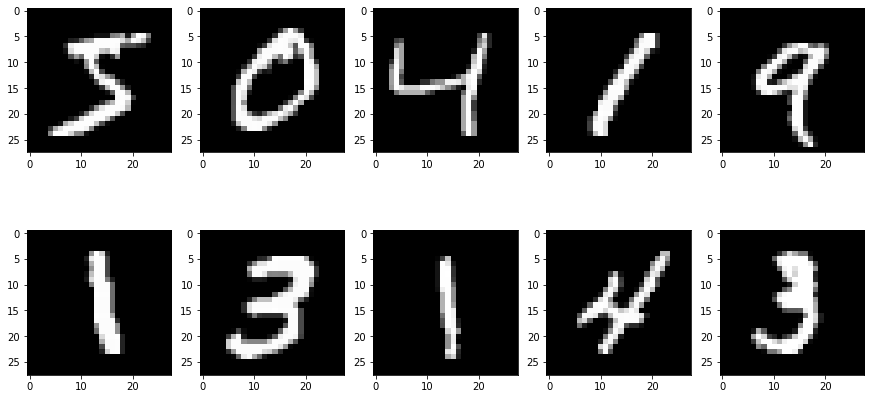

Labels : [5 0 4 1 9]
Labels : [1 3 1 4 3]


In [3]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_train[i], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_train[i+6], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("Labels : {}".format(y_train[0:5]))
print("Labels : {}".format(y_train[6:11]))

In [10]:
num_classes= None
img_rows, img_cols = 28, 28


x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
# input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train_dataset shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)

x_train_dataset shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [11]:
# Copy data to 3 channels and resample to get 56x56 images
# VGG needs atleast 48x48, so resample
# Center and resample diffraction array to desired pixel spacing
from scipy.ndimage.interpolation import zoom

def resample(diff3D, Nx, Ny): 
    nx, ny, nz = diff3D.shape
    diff3D=zoom(diff3D, (float(Nx)/nx,float(Ny)/ny, 1), order=1)
    return diff3D


from tqdm import tqdm
def copy3channels(input_data):
    dims = input_data.shape
    dataset3 = np.zeros((dims[0],28,28,3),float)
    for i in tqdm(range(dims[0])):
        dataset3[i,:,:,0], dataset3[i,:,:,1], dataset3[i,:,:,2] = input_data[i,:,:,0], input_data[i,:,:,0], input_data[i,:,:,0]
    data=[]
    for i in tqdm(range(dims[0])):
        tmp=resample(dataset3[i,:,:,:],56,56)
        data.append(tmp)
    return np.array(data)

In [12]:
x_train_prepro = copy3channels(x_train)
x_test_prepro = copy3channels(x_test)

100%|██████████| 10000/10000 [00:10<00:00, 949.30it/s]


In [7]:
x_train_prepro.shape

(60000, 56, 56, 3)

In [33]:
weight_decay = 0.0005
def vgg_16(input_shape):
    input_tensor=Input(shape=input_shape)
    # x = ZeroPadding2D(padding=(2, 2))(input_tensor)
    x = Conv2D(64, (3, 3), activation='relu', padding='same',
    kernel_regularizer=regularizers.l2(weight_decay), name='block1_conv1')(input_tensor)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)


    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block2_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block3_conv3')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block4_conv3')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(weight_decay), name='fc1')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(weight_decay), name='fc2')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(10, activation='softmax', name='predictions')(x)

    model = Model(inputs=[input_tensor],outputs=[x])

    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    return model


model = vgg_16((56,56,3))

In [34]:
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 56, 56, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
batch_normalization_31 (Batc (None, 56, 56, 64)        256       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_32 (Batc (None, 56, 56, 64)        256       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       7385

In [9]:
nb_epoch = 50
batch_size = 128

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto')

def run_vgg16():
    
    history = LossHistory()
    model.fit(x_train_prepro, y_train_onehot, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=1, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(x_test_prepro, verbose=0)
    return predictions, history

def test_accuracy():
    err = []
    t = 0
    for i in range(predictions.shape[0]):
        if (np.argmax(predictions[i]) == y_test[i]):
            t = t+1
        else:
            err.append(i)
    return t, float(t)*100/predictions.shape[0], err

In [36]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '2'
# time
predictions, history = run_vgg16()
print(model.summary())

Train on 45000 samples, validate on 15000 samples
Epoch 1/50
45000/45000 [==============================] - 93s 2ms/step - loss: 4.7800 - accuracy: 0.9082 - val_loss: 6.6167 - val_accuracy: 0.3548
Epoch 2/50
45000/45000 [==============================] - 88s 2ms/step - loss: 4.5002 - accuracy: 0.9796 - val_loss: 4.4812 - val_accuracy: 0.9803
Epoch 3/50
45000/45000 [==============================] - 88s 2ms/step - loss: 4.4400 - accuracy: 0.9872 - val_loss: 4.4434 - val_accuracy: 0.9837
Epoch 4/50
45000/45000 [==============================] - 88s 2ms/step - loss: 4.3943 - accuracy: 0.9919 - val_loss: 4.3974 - val_accuracy: 0.9896
Epoch 5/50
45000/45000 [==============================] - 88s 2ms/step - loss: 4.3573 - accuracy: 0.9943 - val_loss: 4.3742 - val_accuracy: 0.9872
Epoch 6/50
45000/45000 [==============================] - 88s 2ms/step - loss: 4.3215 - accuracy: 0.9959 - val_loss: 4.3427 - val_accuracy: 0.9885
Epoch 7/50
45000/45000 [==============================] - 88s 2ms/st

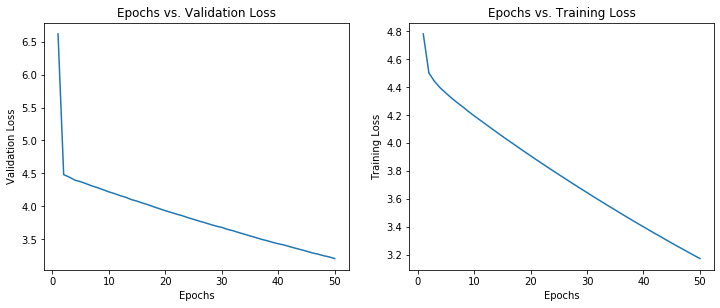

In [37]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,nb_epoch+1), history.val_losses)
ax1.set(xlabel='Epochs', ylabel='Validation Loss',
       title='Epochs vs. Validation Loss')
ax2.plot(np.arange(1,nb_epoch+1), history.losses)
ax2.set(xlabel='Epochs', ylabel='Training Loss',
       title='Epochs vs. Training Loss')
plt.show()

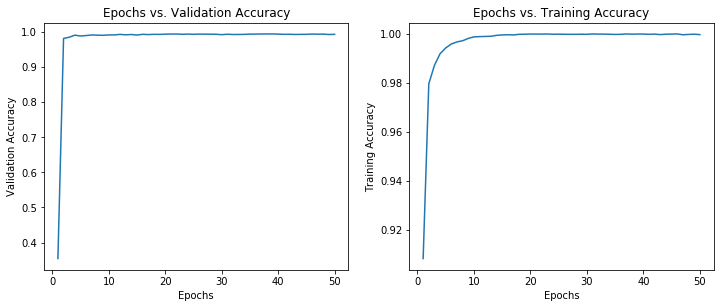

In [38]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,nb_epoch+1), history.val_accuracy)
ax1.set(xlabel='Epochs', ylabel='Validation Accuracy',
       title='Epochs vs. Validation Accuracy')
ax2.plot(np.arange(1,nb_epoch+1), history.accuracy)
ax2.set(xlabel='Epochs', ylabel='Training Accuracy',
       title='Epochs vs. Training Accuracy')
plt.show()

In [39]:
p = test_accuracy()
print("Test accuracy: {} %".format(p[1]))

Test accuracy: 99.22 %


In [40]:
nb_epoch = 10
predictions1, history1 = run_vgg16()

Train on 45000 samples, validate on 15000 samples
Epoch 1/10
45000/45000 [==============================] - 87s 2ms/step - loss: 3.1507 - accuracy: 0.9999 - val_loss: 3.1851 - val_accuracy: 0.9920
Epoch 2/10
45000/45000 [==============================] - 87s 2ms/step - loss: 3.1295 - accuracy: 0.9998 - val_loss: 3.1655 - val_accuracy: 0.9921
Epoch 3/10
45000/45000 [==============================] - 88s 2ms/step - loss: 3.1080 - accuracy: 0.9998 - val_loss: 3.1420 - val_accuracy: 0.9922
Epoch 4/10
45000/45000 [==============================] - 88s 2ms/step - loss: 3.0864 - accuracy: 0.9998 - val_loss: 3.1246 - val_accuracy: 0.9915
Epoch 5/10
45000/45000 [==============================] - 88s 2ms/step - loss: 3.0655 - accuracy: 0.9998 - val_loss: 3.1026 - val_accuracy: 0.9915
Epoch 6/10
45000/45000 [==============================] - 88s 2ms/step - loss: 3.0441 - accuracy: 0.9997 - val_loss: 3.1108 - val_accuracy: 0.9887
Epoch 7/10
45000/45000 [==============================] - 88s 2ms/st

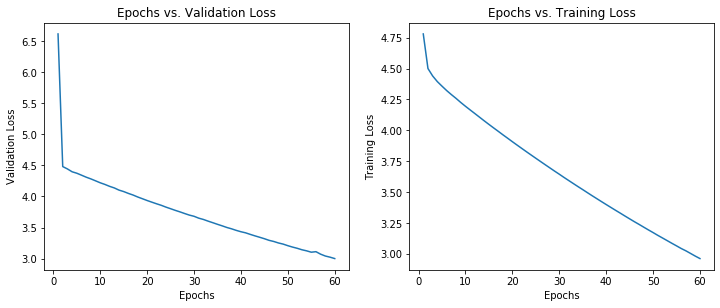

In [41]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,61), history.val_losses+history1.val_losses)
ax1.set(xlabel='Epochs', ylabel='Validation Loss',
       title='Epochs vs. Validation Loss')
ax2.plot(np.arange(1,61), history.losses+history1.losses)
ax2.set(xlabel='Epochs', ylabel='Training Loss',
       title='Epochs vs. Training Loss')
plt.show()

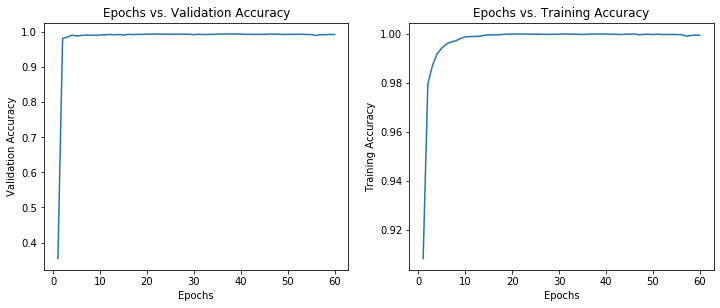

In [42]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,61), history.val_accuracy+history1.val_accuracy)
ax1.set(xlabel='Epochs', ylabel='Validation Accuracy',
       title='Epochs vs. Validation Accuracy')
ax2.plot(np.arange(1,61), history.accuracy+history1.accuracy)
ax2.set(xlabel='Epochs', ylabel='Training Accuracy',
       title='Epochs vs. Training Accuracy')
plt.show()

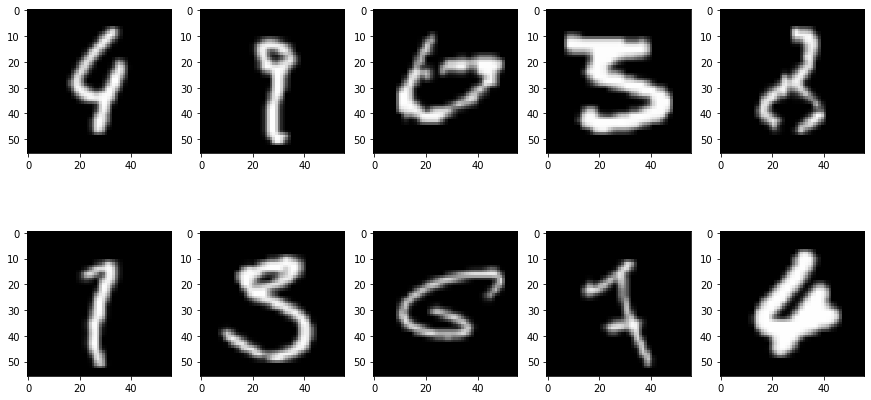

True:          [4 9 6 3 8]
classified as: [9 8 0 5 2]
True:          [1 3 6 7 4]
classified as: [7 5 5 1 6]


In [30]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_test_prepro[p[2][i]], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_test_prepro[p[2][i+6]], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("True:          {}".format(y_test[p[2][0:5]]))
print("classified as: {}".format(np.argmax(predictions[p[2][0:5]], axis=1)))

print("True:          {}".format(y_test[p[2][6:11]]))
print("classified as: {}".format(np.argmax(predictions[p[2][6:11]], axis=1)))

In [1]:
import h5py

In [45]:
model.save_weights('vgg16model_weights.h5')

In [48]:
vggmodel_json = model.to_json()
with open ("vgg16model.json", "w") as json_file:
    json_file.write(vggmodel_json)

In [14]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
from keras.models import model_from_json
json_file = open('vgg16model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("vgg16model_weights.h5")

sgd2=SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
loaded_model.compile(loss='categorical_crossentropy', optimizer = sgd2, metrics=['accuracy'] )

In [15]:
def run_vgg16_2():
    
    history = LossHistory()
    loaded_model.fit(x_train_prepro, y_train_onehot, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=1, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = loaded_model.predict(x_test_prepro, verbose=0)
    return predictions, history

In [16]:
nb_epoch=30
predictions, history = run_vgg16_2()

Train on 45000 samples, validate on 15000 samples
Epoch 1/30
45000/45000 [==============================] - 94s 2ms/step - loss: 3.0176 - accuracy: 0.9705 - val_loss: 2.9203 - val_accuracy: 0.9771
Epoch 2/30
45000/45000 [==============================] - 88s 2ms/step - loss: 2.7645 - accuracy: 0.9878 - val_loss: 2.6644 - val_accuracy: 0.9905
Epoch 3/30
45000/45000 [==============================] - 88s 2ms/step - loss: 2.5702 - accuracy: 0.9909 - val_loss: 2.5031 - val_accuracy: 0.9878
Epoch 4/30
45000/45000 [==============================] - 88s 2ms/step - loss: 2.3934 - accuracy: 0.9936 - val_loss: 2.3510 - val_accuracy: 0.9863
Epoch 5/30
45000/45000 [==============================] - 88s 2ms/step - loss: 2.2368 - accuracy: 0.9937 - val_loss: 2.1832 - val_accuracy: 0.9889
Epoch 6/30
45000/45000 [==============================] - 88s 2ms/step - loss: 2.0833 - accuracy: 0.9947 - val_loss: 2.0592 - val_accuracy: 0.9855
Epoch 7/30
45000/45000 [==============================] - 88s 2ms/st

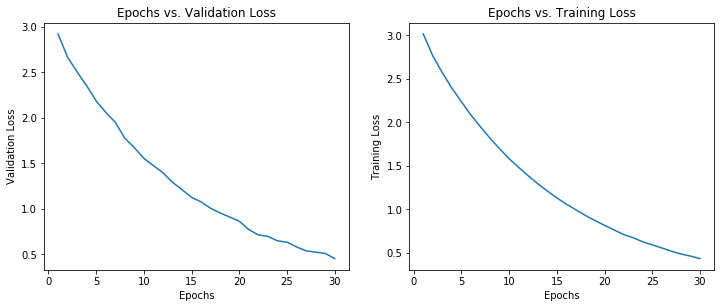

In [17]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,31), history.val_losses)
ax1.set(xlabel='Epochs', ylabel='Validation Loss',
       title='Epochs vs. Validation Loss')
ax2.plot(np.arange(1,31), history.losses)
ax2.set(xlabel='Epochs', ylabel='Training Loss',
       title='Epochs vs. Training Loss')
plt.show()

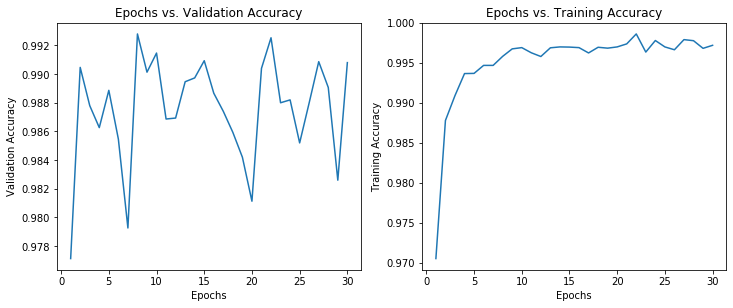

In [18]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,31), history.val_accuracy)
ax1.set(xlabel='Epochs', ylabel='Validation Accuracy',
       title='Epochs vs. Validation Accuracy')
ax2.plot(np.arange(1,31), history.accuracy)
ax2.set(xlabel='Epochs', ylabel='Training Accuracy',
       title='Epochs vs. Training Accuracy')
plt.show()

In [19]:
nb_epoch=20
predictions2, history2 = run_vgg16_2()

Train on 45000 samples, validate on 15000 samples
Epoch 1/20
45000/45000 [==============================] - 88s 2ms/step - loss: 0.4037 - accuracy: 0.9970 - val_loss: 0.4393 - val_accuracy: 0.9891
Epoch 2/20
45000/45000 [==============================] - 88s 2ms/step - loss: 0.3814 - accuracy: 0.9968 - val_loss: 0.4120 - val_accuracy: 0.9909
Epoch 3/20
45000/45000 [==============================] - 88s 2ms/step - loss: 0.3640 - accuracy: 0.9962 - val_loss: 0.3881 - val_accuracy: 0.9899
Epoch 4/20
45000/45000 [==============================] - 88s 2ms/step - loss: 0.3347 - accuracy: 0.9982 - val_loss: 0.3655 - val_accuracy: 0.9901
Epoch 5/20
45000/45000 [==============================] - 88s 2ms/step - loss: 0.3155 - accuracy: 0.9980 - val_loss: 0.3378 - val_accuracy: 0.9923
Epoch 6/20
45000/45000 [==============================] - 88s 2ms/step - loss: 0.3019 - accuracy: 0.9971 - val_loss: 0.3372 - val_accuracy: 0.9901
Epoch 7/20
45000/45000 [==============================] - 88s 2ms/st

In [20]:
nb_epoch=20
predictions3, history3 = run_vgg16_2()

Train on 45000 samples, validate on 15000 samples
Epoch 1/20
45000/45000 [==============================] - 88s 2ms/step - loss: 0.1348 - accuracy: 0.9980 - val_loss: 0.1690 - val_accuracy: 0.9905
Epoch 2/20
45000/45000 [==============================] - 88s 2ms/step - loss: 0.1297 - accuracy: 0.9978 - val_loss: 0.1686 - val_accuracy: 0.9904
Epoch 3/20
45000/45000 [==============================] - 88s 2ms/step - loss: 0.1224 - accuracy: 0.9978 - val_loss: 0.1508 - val_accuracy: 0.9918
Epoch 4/20
45000/45000 [==============================] - 88s 2ms/step - loss: 0.1202 - accuracy: 0.9976 - val_loss: 0.1463 - val_accuracy: 0.9921
Epoch 5/20
45000/45000 [==============================] - 88s 2ms/step - loss: 0.1135 - accuracy: 0.9978 - val_loss: 0.1495 - val_accuracy: 0.9913
Epoch 6/20
45000/45000 [==============================] - 88s 2ms/step - loss: 0.1091 - accuracy: 0.9978 - val_loss: 0.1443 - val_accuracy: 0.9917
Epoch 7/20
45000/45000 [==============================] - 88s 2ms/st

In [21]:
nb_epoch=20
predictions4, history4 = run_vgg16_2()

Train on 45000 samples, validate on 15000 samples
Epoch 1/20
45000/45000 [==============================] - 89s 2ms/step - loss: 0.0656 - accuracy: 0.9982 - val_loss: 0.0959 - val_accuracy: 0.9926
Epoch 2/20
45000/45000 [==============================] - 89s 2ms/step - loss: 0.0680 - accuracy: 0.9975 - val_loss: 0.0925 - val_accuracy: 0.9913
Epoch 3/20
45000/45000 [==============================] - 88s 2ms/step - loss: 0.0645 - accuracy: 0.9981 - val_loss: 0.0962 - val_accuracy: 0.9913
Epoch 4/20
45000/45000 [==============================] - 88s 2ms/step - loss: 0.0586 - accuracy: 0.9990 - val_loss: 0.0887 - val_accuracy: 0.9931
Epoch 5/20
45000/45000 [==============================] - 89s 2ms/step - loss: 0.0572 - accuracy: 0.9988 - val_loss: 0.0892 - val_accuracy: 0.9928
Epoch 6/20
45000/45000 [==============================] - 89s 2ms/step - loss: 0.0592 - accuracy: 0.9977 - val_loss: 0.1018 - val_accuracy: 0.9898
Epoch 7/20
45000/45000 [==============================] - 89s 2ms/st

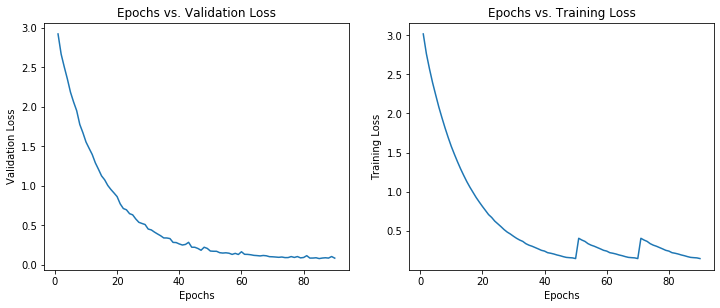

In [22]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,91), history.val_losses+history2.val_losses+history3.val_losses+history4.val_losses)
ax1.set(xlabel='Epochs', ylabel='Validation Loss',
       title='Epochs vs. Validation Loss')
ax2.plot(np.arange(1,91), history.losses+history2.losses+history2.losses+history2.losses)
ax2.set(xlabel='Epochs', ylabel='Training Loss',
       title='Epochs vs. Training Loss')
plt.show()

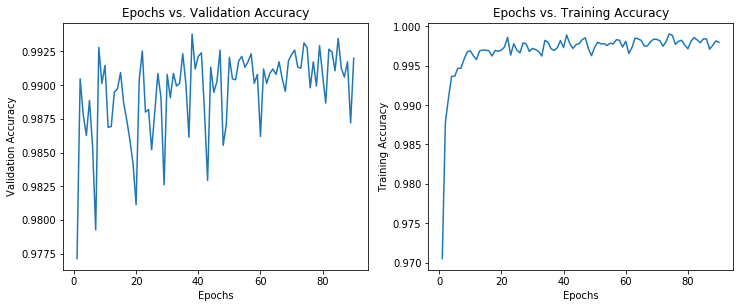

In [23]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,91), history.val_accuracy+history2.val_accuracy+history3.val_accuracy+history4.val_accuracy)
ax1.set(xlabel='Epochs', ylabel='Validation Accuracy',
       title='Epochs vs. Validation Accuracy')
ax2.plot(np.arange(1,91), history.accuracy+history2.accuracy+history3.accuracy+history4.accuracy)
ax2.set(xlabel='Epochs', ylabel='Training Accuracy',
       title='Epochs vs. Training Accuracy')
plt.show()

In [24]:
def test_accuracy2():
    err = []
    t = 0
    for i in range(predictions4.shape[0]):
        if (np.argmax(predictions4[i]) == y_test[i]):
            t = t+1
        else:
            err.append(i)
    return t, float(t)*100/predictions4.shape[0], err

In [25]:
p = test_accuracy()
print("Test accuracy: {} %".format(p[1]))

Test accuracy: 99.35 %


In [28]:
import h5py
loaded_model.save_weights('mnist_regu_2_lr-2_weights.h5')
vggmodel_json = loaded_model.to_json()
with open ("mnist_regu_2_lr-2.json", "w") as json_file:
    json_file.write(vggmodel_json)